In [1]:
from dataset import WeatherCO2DataModule
import torch
import numpy as np

torch.manual_seed(0)

weather_points_dataset = np.load("weather_data_2021-2023.npy", allow_pickle=True)
emission_data = np.load("emission_data_2021-2023.npy", allow_pickle=True)

datetimes = list(range(len(emission_data)))

dm = WeatherCO2DataModule(
    weather_points_dataset,
    emission_data,
    datetimes,
    96,
    24,
    num_workers=2,
    batch_size=32,
    split_sizes=[0.8, 0.2, 0.0],
)
dm.setup('fit')

2023-06-06 15:32:45.859188: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-06 15:32:45.918194: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-06 15:32:46.787799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from model import TCNModel
from lightning.pytorch import Trainer
import os 

model = TCNModel(
    {
        "num_inputs": 22 * 40,
        "num_channels": [512, 128],
        "kernel_size": 4,
        "dropout": 0.2,
    },
    96,
    24,
    "Adam",
    {"lr": 1e-4, "weight_decay": 1e-5},
)

# For WandB local checkpoints
# def find_checkpoint(name):
#     folder = f'SmartScheduler/{name}/checkpoints'
#     for file in os.listdir(folder):
#         if file.endswith('.ckpt'):
#             return f'{folder}/{file}'

# model = model.load_from_checkpoint(find_checkpoint('36n1rglx'))

# model.ckpt can be downloaded here:
# https://api.wandb.ai/artifactsV2/gcp-us/mtyutyulnikov/QXJ0aWZhY3Q6NDc3MDUyNjUw/6c14bec74f1261169f7b083c1d27c6a9/model.ckpt?_gl=1*brpj4j*_ga*Mjk0MzUwODY2LjE2ODU2NzQ2NDY.*_ga_JH1SJHJQXJ*MTY4NjAzOTk3MC4xNi4xLjE2ODYwMzk5OTUuMzUuMC4w

model = model.load_from_checkpoint('model.ckpt')

trainer = Trainer(
    accelerator="gpu",
    devices=[0],
)

val_preds = trainer.predict(model, dm.val_dataloader())


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/lazarev/disk/tiutiulnikov/miniconda3/envs/eco2ai/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [3]:
len(val_preds), val_preds[0].shape, val_preds[-1].shape

(122, torch.Size([32, 24]), torch.Size([16, 24]))

In [4]:
concat_preds = dm.val_dataset.target_scaler.inverse_transform(torch.concat(val_preds, 0))
val = [dm.val_dataset[idx][1] for idx in range(len(dm.val_dataset))]

val = torch.stack(val)
val = dm.val_dataset.target_scaler.inverse_transform(val)

In [5]:
concat_preds.shape, val.shape

((3888, 24), (3888, 24))

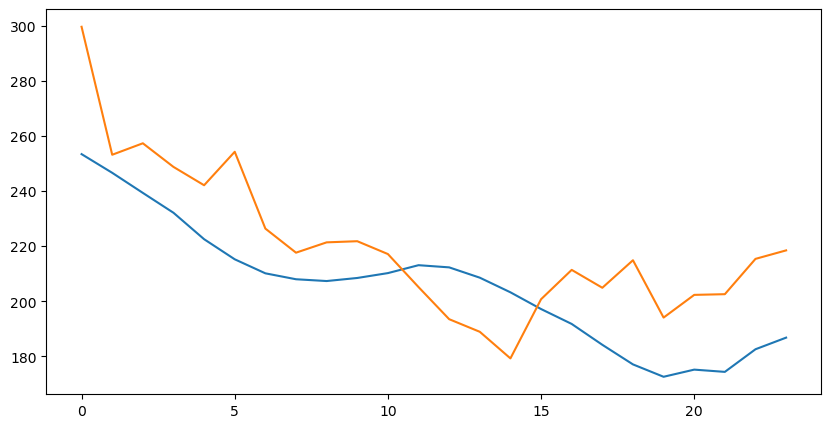

In [6]:
import matplotlib.pyplot as plt

sample_id = 100
plt.figure(figsize=(10, 5))
plt.plot(concat_preds[sample_id], label='pred')
plt.plot(val[sample_id] , label='val')

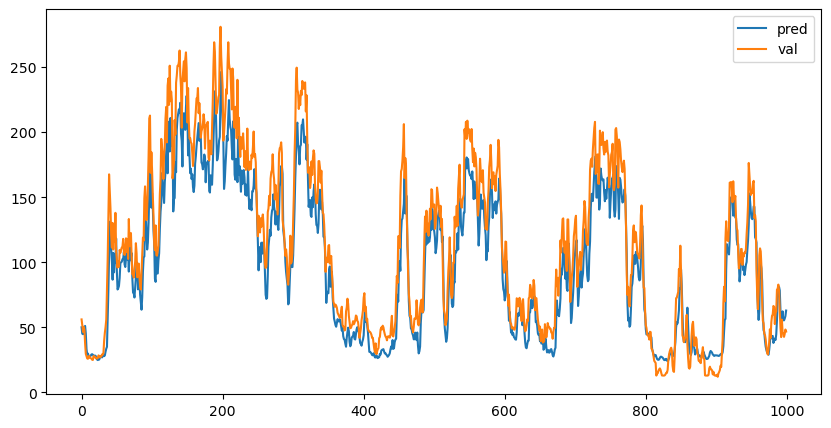

In [7]:
import matplotlib.pyplot as plt

time_step = 0
s1, s2 = 1000, 2000
plt.figure(figsize=(10, 5))
plt.plot(concat_preds[s1 :s2, time_step], label='pred')
plt.plot(val[s1 :s2, time_step] , label='val')
plt.legend()

In [8]:
from sklearn.metrics import mean_absolute_error
for i in range(24):
    print(f'Forecast time_step {i}: \t MAE = {mean_absolute_error(concat_preds[:, i], val[:, i])}')

Forecast time_step 0: 	 MAE = 17.74480478083549
Forecast time_step 1: 	 MAE = 21.101456481719936
Forecast time_step 2: 	 MAE = 24.146995309989094
Forecast time_step 3: 	 MAE = 26.687809722916516
Forecast time_step 4: 	 MAE = 28.982013470119885
Forecast time_step 5: 	 MAE = 30.625970024787346
Forecast time_step 6: 	 MAE = 31.8273896016079
Forecast time_step 7: 	 MAE = 32.816268625466684
Forecast time_step 8: 	 MAE = 33.666374371847525
Forecast time_step 9: 	 MAE = 34.53783894224698
Forecast time_step 10: 	 MAE = 35.37953949290184
Forecast time_step 11: 	 MAE = 36.32807018062898
Forecast time_step 12: 	 MAE = 37.414657195236266
Forecast time_step 13: 	 MAE = 38.34425909519696
Forecast time_step 14: 	 MAE = 39.2470047819054
Forecast time_step 15: 	 MAE = 39.93270031289728
Forecast time_step 16: 	 MAE = 40.43275827026908
Forecast time_step 17: 	 MAE = 40.880524204665356
Forecast time_step 18: 	 MAE = 41.13817548110971
Forecast time_step 19: 	 MAE = 41.362398458190015
Forecast time_step 20:

In [9]:
val.shape

(3888, 24)

In [10]:
concat_preds.shape

(3888, 24)

In [11]:
print(f'Total MAE = {mean_absolute_error(concat_preds, val)}')

Total MAE = 35.010159721806964


In [17]:
def print_res(predict_period):
    preds = []
    real = []

    plt.figure(figsize=(20, 5))


    for i in range(0, len(val), predict_period):
        preds.extend(concat_preds[i, :predict_period])
        real.extend(val[i, :predict_period])
        # plt.axvline(i, color='r', ds='steps-pre')

    plt.plot(preds, label = f'forecast_{predict_period}h_step')
    plt.plot(real, label='real_val')
    plt.legend()
    print(preds[0])

    print(mean_absolute_error(preds, real).round(2))

3888
33.47


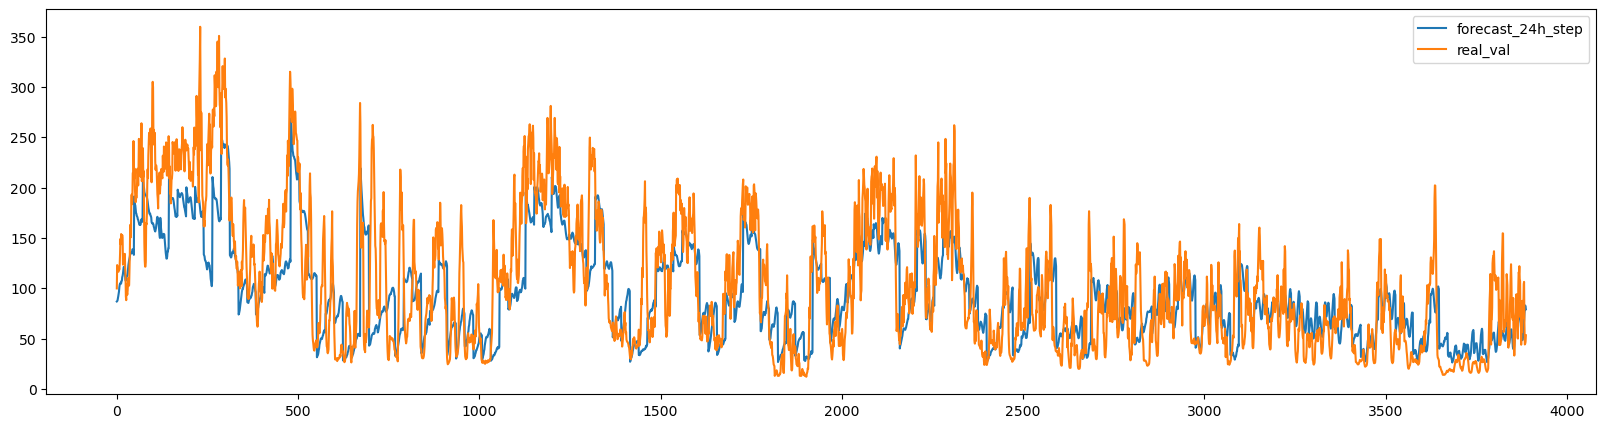

In [18]:
print_res(24)

28.12


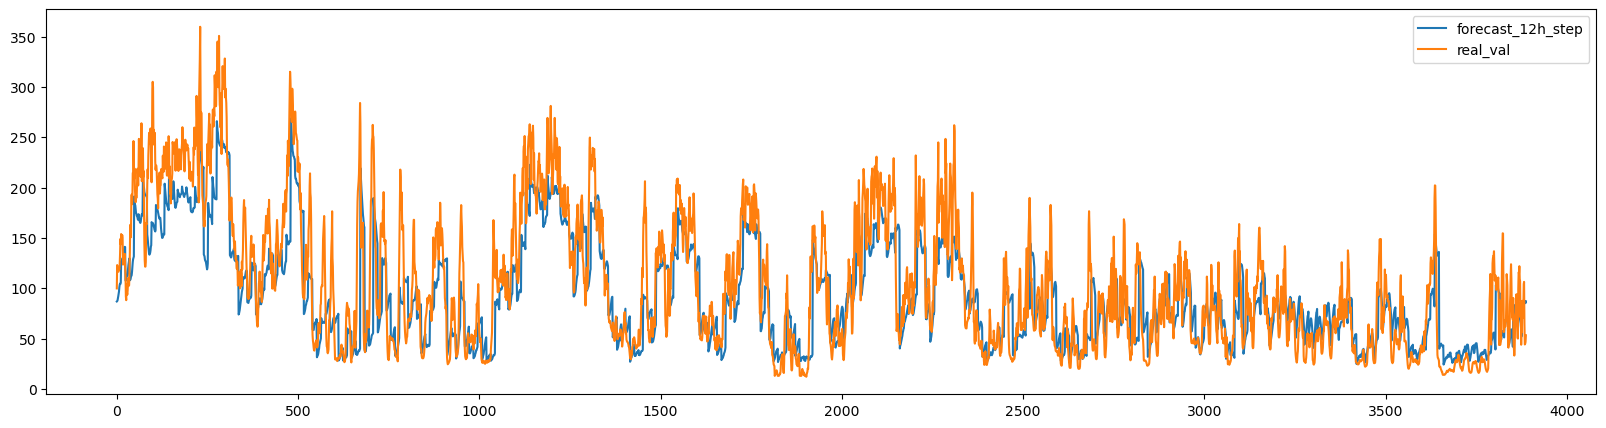

In [14]:
print_res(12)

24.59


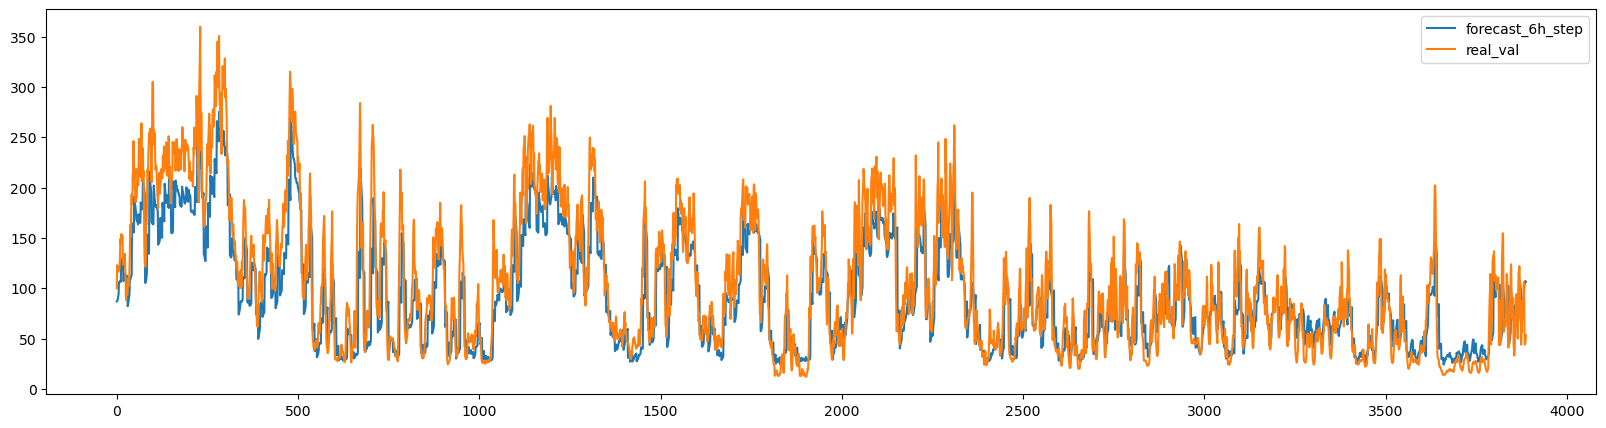

In [15]:
print_res(6)

17.74


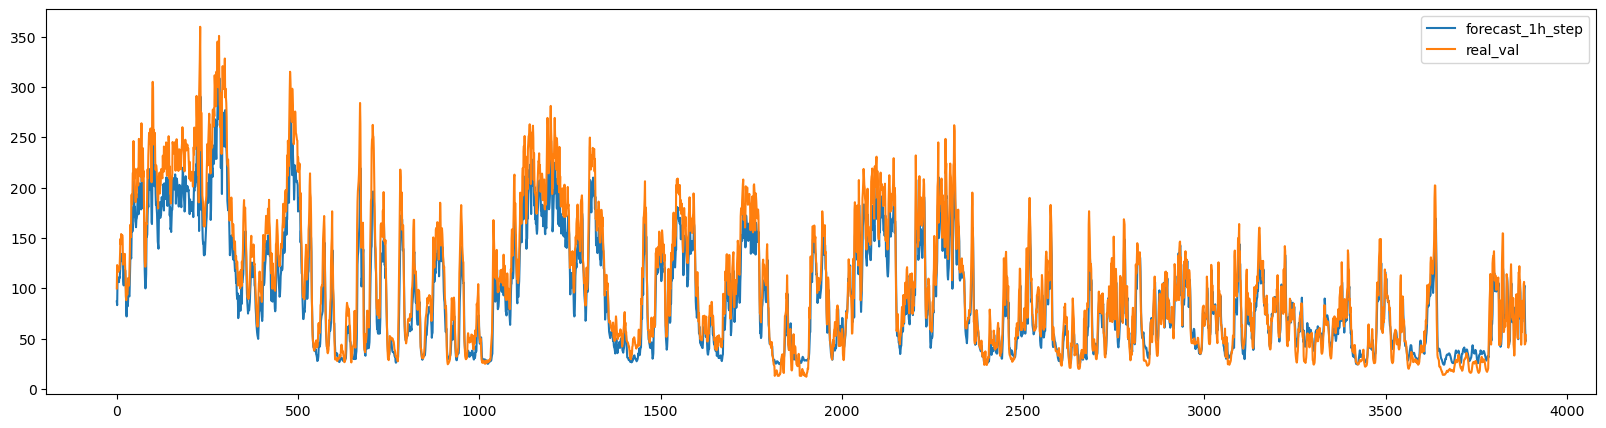

In [16]:
print_res(1)